In [5]:
import dgl
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from ogb.nodeproppred import DglNodePropPredDataset

dataset = DglNodePropPredDataset(name = "ogbn-arxiv")

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph, label = dataset[0] # graph: dgl graph object, label: torch tensor of shape (num_nodes, num_tasks)

In [10]:
gx = dgl.to_networkx(graph)

In [14]:
# function to generate random walk sequences of nodes
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(gx.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [15]:
get_randomwalk(0, 5)

[0, 52893, 14528, 71730]

In [16]:
all_nodes = list(gx.nodes())

random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,5))

100%|███████████████████████████████████████████████████████████████████████| 169343/169343 [00:14<00:00, 11985.32it/s]


In [17]:
# count of sequences
len(random_walks)

846715

In [19]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [20]:
# train word2vec model
model = Word2Vec(vector_size=150, window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

In [21]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(62561354, 63571960)

In [28]:
embs = []
for key in range(label.shape[0]):
    embs.append(model.wv.get_vector(key))

In [43]:
from sklearn.manifold import TSNE

In [55]:
from sklearn.model_selection import train_test_split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(embs, label, test_size=0.0005, random_state=42)

In [143]:
samp = []
y_samp = []
for i in range(len(embs)):
    if( label[i][0]<= 4):
        samp.append(embs[i])
        y_samp.append(label[i][0])

In [145]:
tsne3 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne3_results = tsne3.fit_transform(samp)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14033 samples in 0.003s...
[t-SNE] Computed neighbors for 14033 samples in 6.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14033
[t-SNE] Computed conditional probabilities for sample 2000 / 14033
[t-SNE] Computed conditional probabilities for sample 3000 / 14033
[t-SNE] Computed conditional probabilities for sample 4000 / 14033
[t-SNE] Computed conditional probabilities for sample 5000 / 14033
[t-SNE] Computed conditional probabilities for sample 6000 / 14033
[t-SNE] Computed conditional probabilities for sample 7000 / 14033
[t-SNE] Computed conditional probabilities for sample 8000 / 14033
[t-SNE] Computed conditional probabilities for sample 9000 / 14033
[t-SNE] Computed conditional probabilities for sample 10000 / 14033
[t-SNE] Computed conditional probabilities for sample 11000 / 14033
[t-SNE] Computed conditional probabilities for sample 12000 / 14033
[t-SNE] Computed conditional probabilities for sa

In [154]:
test_df2 = pd.DataFrame()
test_df2['1st'] = tsne3_results[:, 0]
test_df2['2nd'] = tsne3_results[:, 1]
test_df2['label']= y_samp
test_df2.head()

,1st,2nd,label
0,1.922285,-9.196269,4
1,-5.001977,2.883154,4
2,-0.106884,-0.715958,3
3,-9.554946,-1.934264,3
4,0.860059,-0.614717,4


In [153]:
y_samp = []
yyy = label.numpy() 
for i in range(len(embs)):
    if( yyy[i][0]<= 4):
        y_samp.append(yyy[i][0])

<AxesSubplot:xlabel='1st', ylabel='2nd'>

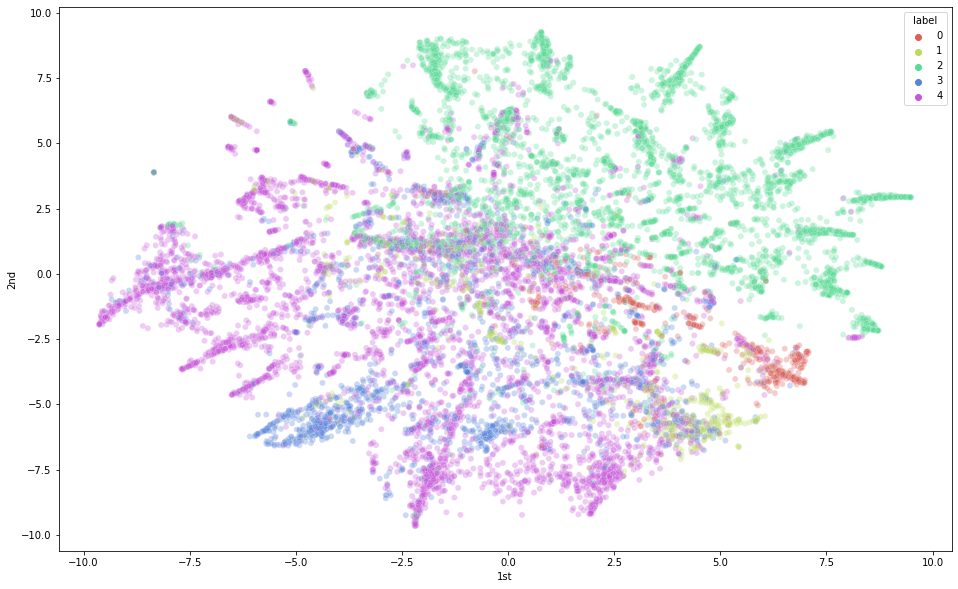

In [155]:
# df_subset['tsne-2d-one'] = tsne_results[:,0]
# df_subset['tsne-2d-two'] = tsne_results[:,1]
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="1st", y="2nd",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=test_df2,
    legend="full",
    alpha=0.3
)

In [156]:
yyyy = label.numpy()

In [158]:
yyyy.reshape(-1)
yyyy.shape

(169343, 1)

In [162]:
y_f = []
for i in range(yyyy.shape[0]):
    y_f.append(yyyy[i][0])

In [164]:
len(y_f)

169343

In [167]:
from collections import defaultdict 
# from karateclub import Node2Vec 
# from ogb.nodeproppred import PygNodePropPredDataset 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
# from torch_geometric.utils import to_networkx
from typing import List 
from tqdm import tqdm 
# from gensim.models import Word2Vec 

import matplotlib.pyplot as plt 
# import networkx as nx 
import numpy as np 
import pandas as pd 
import random 
import torch 

In [168]:
X_train, X_test, y_train, y_test = train_test_split(embs, y_f, random_state=42, test_size=0.3) 
model = LogisticRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 
print(accuracy_score(y_test,y_pred))

0.5913430309233707
